In [6]:
import sys
sys.path.append('/home/lpsha/s154446/fractality/dual_graph_algo/')

import dual_conti

from importlib import reload
reload(dual_conti)

import pandas as pd
import geopandas as gpd

from pyrosm import OSM, get_data
import osmnx as ox
import momepy

import matplotlib.pyplot as plt
import numpy as np
import powerlaw

from importlib import reload
reload(dual_conti)

<module 'dual_conti' from '/home/lpsha/s154446/fractality/dual_graph_algo/dual_conti.py'>

# input Pyrosm vs OSMNX

In [ ]:
fp = get_data('Isle of Man')
osm = OSM(fp)
_, shape_df = osm.get_network(nodes=True)
gdf_merged, H = dual_conti.get_dual_dir_con(t_buffer=5, a_threshold=30, data=shape_df)

pyrosm GeoDataFrame


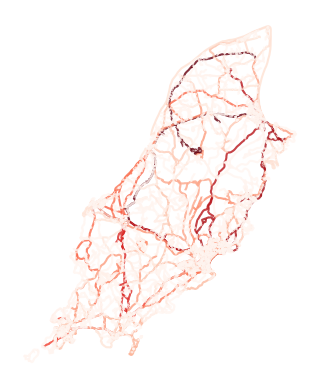

In [67]:
gdf_merged['degree_log'] = gdf_merged['degree'].apply(np.log10)
gdf_merged.plot(column='degree_log',vmin=1,cmap='Reds',alpha=0.8)
plt.axis('off')
plt.show()

In [68]:
place_name = "Isle of Man"
G = ox.graph_from_place(place_name, network_type="all")
gdf_merged_ox, H = dual_conti.get_dual_dir_con(t_buffer=5, a_threshold=30, data=G)

osmnx graph


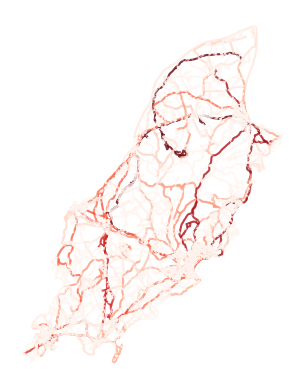

In [69]:
gdf_merged_ox['degree_log'] = gdf_merged_ox['degree'].apply(np.log10)
gdf_merged_ox.plot(column='degree_log',vmin=1,cmap='Reds',alpha=0.8)
plt.axis('off')
plt.show()

In [79]:
def compute_ks(degree,min_range):
    distance = []
    for i_min in min_range:
        fit = powerlaw.Fit(degree,discrete=True,xmin=i_min)
        a = fit.alpha
        xmin = fit.xmin
        x_fit = degree[degree>xmin]
        distance.append(fit.power_law.D)

    return np.array(distance), min_range

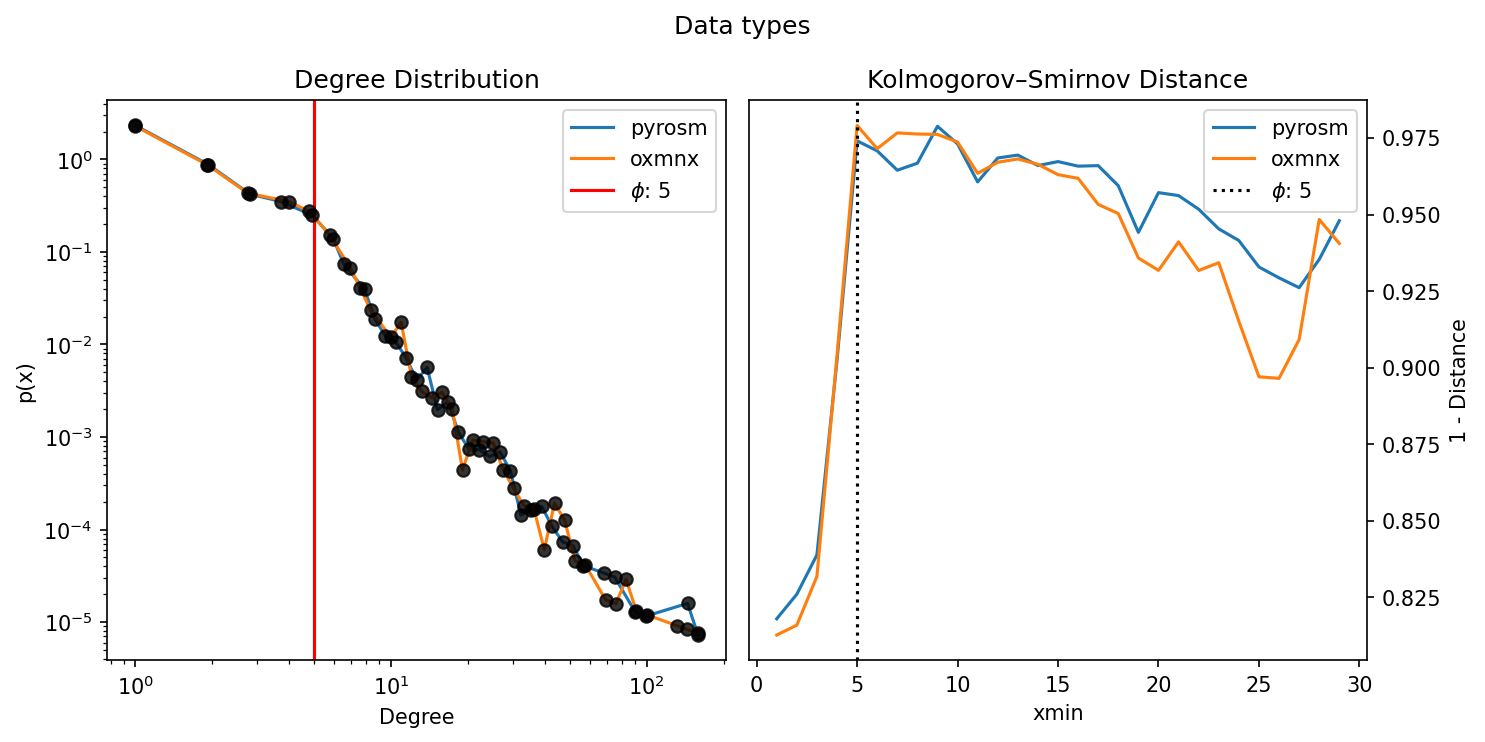

In [ ]:
ps = 5

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5),dpi=150)
axs = axs.ravel()
ax = axs[0]

d_type = ['pyrosm','oxmnx',]

# Histogram data
for enu, degree_obs_val in enumerate([gdf_merged.degree.values, gdf_merged_ox.degree.values]):
    
    y, x = np.histogram(degree_obs_val, bins=np.logspace(0, np.log10(degree_obs_val.max()), len(np.unique(degree_obs_val))), density=True)
    x = x[:-1]
    x_nn = x[y != 0][:-1]
    y_nn = y[y != 0][:-1]
    ax.scatter(x_nn, y_nn, alpha=0.8, zorder=3, color='k')
    ax.plot(x_nn, y_nn, alpha=1, zorder=2,label=d_type[enu])
    ax.set_ylabel('p(x)')
    ax.set_xlabel('Degree')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title("Degree Distribution")

    ks_dist, xmins = compute_ks(degree_obs_val[degree_obs_val!=0], range(1,30))
    ax2 = axs[1]
    # ax2.scatter(xmins,1-ks_dist,color='red')
    ax2.plot(xmins,1-ks_dist,label=d_type[enu])
    ax2.set_xlabel('xmin')
    ax2.set_ylabel('1 - Distance')
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    ax2.set_title('Kolmogorov–Smirnov Distance')

ax.axvline(ps,label=f'$\phi$: {ps}',color='red')
ax2.axvline(ps,color='k',linestyle='dotted',label='$\phi$: '+str(ps))
ax2.legend()
ax.legend()

plt.suptitle('Data types')
plt.tight_layout()
plt.show()

In [106]:
print(len(gdf_merged))
print(len(gdf_merged_ox))

8895
8615


In [7]:
from importlib import reload
reload(dual_conti)


fp = get_data('Monaco')
osm = OSM(fp)
_, shape_df = osm.get_network(nodes=True)
gdf_merged, H = dual_conti.get_dual_dir_con(t_buffer=5, a_threshold=30, data=shape_df)

pyrosm GeoDataFrame


KeyboardInterrupt: 

# Frederiksberg

In [13]:
# from importlib import reload
reload(dual_conti)

<module 'dual_conti' from '/home/lpsha/s154446/fractality/dual_graph_algo/dual_conti.py'>

In [14]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  
gdf_merged_ox, H, _, _ = dual_conti.get_dual_dir_con(t_buffer=10, a_threshold=30, data=G)

osmnx graph


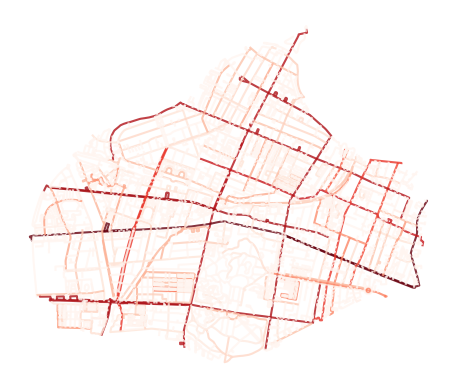

In [15]:
gdf_merged_ox['degree_log'] = gdf_merged_ox['degree'].apply(np.log10)
gdf_merged_ox.plot(column='degree_log',cmap='Reds',alpha=0.8,vmin=1)
plt.axis('off')
plt.show()

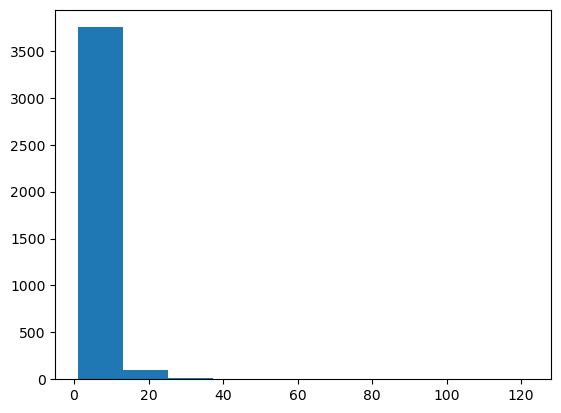

In [76]:
plt.hist(gdf_merged_ox['degree'].values)
plt.show()

# sub G

In [121]:
import networkx as nx

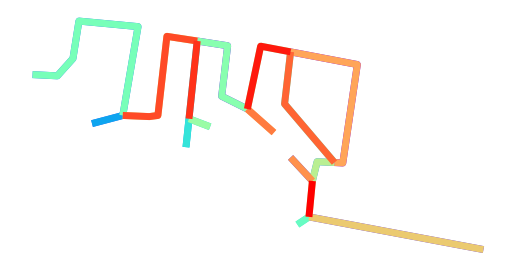

In [181]:
place_name = "Frederiksberg Municipality, Denmark"
G = ox.graph_from_place(place_name, network_type="all")  

# for s in [52,21,12]:
np.random.seed(214) 
start = np.random.choice(list(G.nodes))

nodes_within_N = nx.single_source_shortest_path_length(G, start, cutoff=4)
subG = G.subgraph(nodes_within_N.keys()).copy()
shape_df = ox.graph_to_gdfs(subG,nodes=False)
shape_df.crs = "epsg:4326"
shape_df = shape_df.to_crs(3857)

fig, ax = plt.subplots()
shape_df.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()

In [183]:
reload(dual_conti)
gdf_merged_ox, H, shape_exploded = dual_conti.get_dual_dir_con(t_buffer=10, 
                                               a_threshold=30, 
                                               data=shape_df,
                                               enforce_degree2=False)

pyrosm GeoDataFrame


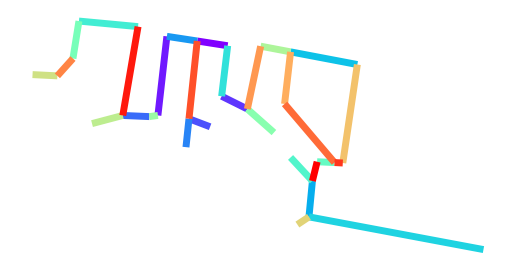

In [230]:
fig, ax = plt.subplots()
shape_exploded.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()

pyrosm GeoDataFrame


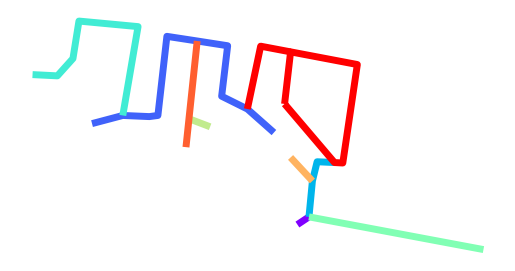

In [271]:
reload(dual_conti)
gdf_merged_ox, H, shape_exploded, lines = dual_conti.get_dual_dir_con(t_buffer=2, 
                                               a_threshold=40, 
                                               data=shape_df,
                                               enforce_degree2=True)
fig, ax = plt.subplots()
gdf_merged_ox.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()

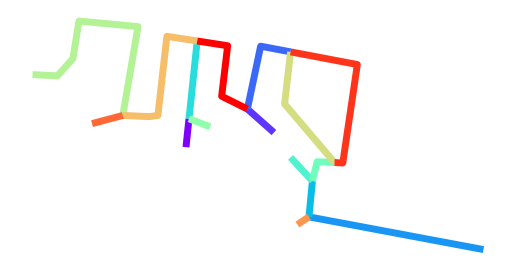

In [272]:
fig, ax = plt.subplots()
lines.sample(frac=1).plot(cmap='rainbow',ax=ax,linewidth=5)
ax.axis('off')
plt.show()